Reference

https://github.com/sweetcocoa/IKC

https://github.com/yuanjunchai/IKC

In [1]:
import os
import torch

In [2]:
# import module
from IKC.model.SFTMD import SFTMD
from IKC.model.Predictor import Predictor
from IKC.model.Corrector import Corrector

from utils.gaussian_kernel import make_and_save
from utils.dataset import get_datasets
from utils.dataloader import get_dataloader
from utils.plot_image import plot
from utils.utils import tensor2imgtensor

from IKC.codes.train_sftmd import train_sftmd
from IKC.codes.train_ikc import train_IKC
from IKC.codes.test import test

In [3]:
print(torch.__version__)
print(torch.cuda.is_available())

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

1.13.0+cu116
True


hyperparameters

In [4]:
args = dict(
    train = './data/train/',
    valid = './data/valid/',
    test = './data/test/Set5',
    kernel_path = './IKC',
    kernel_num = 10000,
    reduced_kernel_dim = 10,
    scale = 4,
    batch_size = 16,
    lr = 1e-4,
    beta1 = 0.9,
    beta2 = 0.99,
    step_size = 10,
    gamma = 0.9,
    num_epoch_sftmd = 50,
    num_epoch_IKC = 50,
    num_iter = 7,
    device = device,
    log_interval = 50,
    ckpt_dir = './IKC/checkpoints',
    sftmd_train = True,
    IKC_train = True,
)

Make Gausian Kernels and Save Kernels

In [5]:
make_and_save(args)

creating kernel dict is complete


Load Datasets

In [6]:
train_ds, valid_ds, test_ds = get_datasets(args)

In [7]:
train_dl = get_dataloader(train_ds, args['batch_size'], shuffle=True)
valid_dl = get_dataloader(valid_ds, args['batch_size'], shuffle=False)
test_dl = get_dataloader(test_ds, 1, shuffle=False)

HR image shape:		 torch.Size([3, 144, 144])
LR image shape:		 torch.Size([3, 36, 36])
kernel shape:		 (21, 21)
reduced kernel shape:	 (10,)
num of train image:	 3450


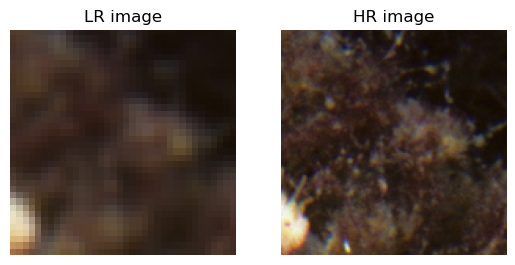

In [8]:
print('HR image shape:\t\t', train_ds[0]['HR'].shape)
print('LR image shape:\t\t', train_ds[0]['LR'].shape)
print('kernel shape:\t\t', train_ds[0]['kernel'].shape)
print('reduced kernel shape:\t', train_ds[0]['reduced_kernel'].shape)
print('num of train image:\t', len(train_ds))

img1 = train_ds[0]
HR, LR = img1['HR'], img1['LR']
plot([tensor2imgtensor(LR), tensor2imgtensor(HR)], ['LR image', 'HR image'], (1, 2))

Train SFTMD

In [9]:
sftmd = SFTMD(3, args['reduced_kernel_dim'], 64, 16, args['scale'])

if args['sftmd_train']:
    print("train sftmd start")
    train_sftmd(train_dl, valid_dl, len(train_ds), sftmd, args)
    print("train sftmd end")

ckpt_path = os.path.join(args['ckpt_dir'], f"ckpt_sftmd_x{args['scale']}.pth")
sftmd.load_state_dict(torch.load(ckpt_path)['model_state_dict'])
print("load sftmd:", ckpt_path)

train sftmd start
Fri Mar 24 08:18:11 2023	Epoch 1:[800/3450]	train [mse: 0.06681  ssim: 0.31229  psnr: 15.57002]
Fri Mar 24 08:18:56 2023	Epoch 1:[1600/3450]	train [mse: 0.04630  ssim: 0.37734  psnr: 16.48393]
Fri Mar 24 08:19:42 2023	Epoch 1:[2400/3450]	train [mse: 0.03801  ssim: 0.35907  psnr: 16.31661]
Fri Mar 24 08:20:27 2023	Epoch 1:[3200/3450]	train [mse: 0.03320  ssim: 0.47999  psnr: 17.83101]
Fri Mar 24 08:20:47 2023	Epoch 1:		valid [mse: 0.01668  ssim: 0.47197  psnr: 18.14873]
sftmd : new best validation loss!
Fri Mar 24 08:21:30 2023	Epoch 2:[800/3450]	train [mse: 0.01286  ssim: 0.58332  psnr: 22.08865]
Fri Mar 24 08:22:12 2023	Epoch 2:[1600/3450]	train [mse: 0.01158  ssim: 0.57889  psnr: 21.25132]
Fri Mar 24 08:22:56 2023	Epoch 2:[2400/3450]	train [mse: 0.01074  ssim: 0.49673  psnr: 19.88398]
Fri Mar 24 08:23:39 2023	Epoch 2:[3200/3450]	train [mse: 0.01028  ssim: 0.59116  psnr: 21.11860]
Fri Mar 24 08:23:58 2023	Epoch 2:		valid [mse: 0.00908  ssim: 0.55266  psnr: 20.60299]


Fri Mar 24 09:11:07 2023	Epoch 17:[3200/3450]	train [mse: 0.00374  ssim: 0.65991  psnr: 24.16571]
Fri Mar 24 09:11:26 2023	Epoch 17:		valid [mse: 0.00323  ssim: 0.76337  psnr: 25.09312]
Fri Mar 24 09:12:08 2023	Epoch 18:[800/3450]	train [mse: 0.00365  ssim: 0.70406  psnr: 22.78457]
Fri Mar 24 09:12:50 2023	Epoch 18:[1600/3450]	train [mse: 0.00376  ssim: 0.78020  psnr: 25.90066]
Fri Mar 24 09:13:33 2023	Epoch 18:[2400/3450]	train [mse: 0.00376  ssim: 0.80811  psnr: 25.94078]
Fri Mar 24 09:14:16 2023	Epoch 18:[3200/3450]	train [mse: 0.00366  ssim: 0.70523  psnr: 24.80952]
Fri Mar 24 09:14:35 2023	Epoch 18:		valid [mse: 0.00359  ssim: 0.73960  psnr: 24.54031]
Fri Mar 24 09:15:17 2023	Epoch 19:[800/3450]	train [mse: 0.00370  ssim: 0.77296  psnr: 27.21273]
Fri Mar 24 09:16:00 2023	Epoch 19:[1600/3450]	train [mse: 0.00372  ssim: 0.68466  psnr: 22.54537]
Fri Mar 24 09:16:42 2023	Epoch 19:[2400/3450]	train [mse: 0.00377  ssim: 0.72866  psnr: 24.41344]
Fri Mar 24 09:17:24 2023	Epoch 19:[3200/34

Fri Mar 24 10:03:48 2023	Epoch 34:[3200/3450]	train [mse: 0.00340  ssim: 0.76851  psnr: 27.35002]
Fri Mar 24 10:04:07 2023	Epoch 34:		valid [mse: 0.00343  ssim: 0.75628  psnr: 24.81098]
Fri Mar 24 10:04:49 2023	Epoch 35:[800/3450]	train [mse: 0.00326  ssim: 0.75263  psnr: 24.99718]
Fri Mar 24 10:05:32 2023	Epoch 35:[1600/3450]	train [mse: 0.00350  ssim: 0.77294  psnr: 24.75490]
Fri Mar 24 10:06:15 2023	Epoch 35:[2400/3450]	train [mse: 0.00351  ssim: 0.74512  psnr: 24.57586]
Fri Mar 24 10:06:57 2023	Epoch 35:[3200/3450]	train [mse: 0.00342  ssim: 0.74044  psnr: 24.42924]
Fri Mar 24 10:07:16 2023	Epoch 35:		valid [mse: 0.00353  ssim: 0.75704  psnr: 24.85020]
Fri Mar 24 10:07:58 2023	Epoch 36:[800/3450]	train [mse: 0.00351  ssim: 0.77495  psnr: 24.85725]
Fri Mar 24 10:08:41 2023	Epoch 36:[1600/3450]	train [mse: 0.00337  ssim: 0.72360  psnr: 22.55179]
Fri Mar 24 10:09:24 2023	Epoch 36:[2400/3450]	train [mse: 0.00349  ssim: 0.78484  psnr: 25.85306]
Fri Mar 24 10:10:07 2023	Epoch 36:[3200/34

Train Predictor and Corrector

In [10]:
predictor = Predictor(3, args['reduced_kernel_dim'], 64)
corrector = Corrector(3, args['reduced_kernel_dim'], 64)

if args['IKC_train']:
    print("train predictor and corrector start")
    train_IKC(train_dl, valid_dl, len(train_ds), sftmd, predictor, corrector, args)
    print("train predictor and corrector end")
    
ckpt_path_p = os.path.join(args['ckpt_dir'], f"ckpt_predictor_x{args['scale']}.pth")
ckpt_path_c = os.path.join(args['ckpt_dir'], f"ckpt_corrector_x{args['scale']}.pth")
predictor.load_state_dict(torch.load(ckpt_path_p)['model_state_dict'])
corrector.load_state_dict(torch.load(ckpt_path_c)['model_state_dict'])
print("load predictor:", ckpt_path_p)
print("load corrector:", ckpt_path_c)

train predictor and corrector start
Fri Mar 24 10:55:49 2023	Epoch 1:[800/3450]	train [predictor: 0.00834  corrector: 0.01629  ssim: 0.69091  psnr: 22.90216]
Fri Mar 24 10:57:52 2023	Epoch 1:[1600/3450]	train [predictor: 0.00756  corrector: 0.01178  ssim: 0.65829  psnr: 21.44005]
Fri Mar 24 10:59:55 2023	Epoch 1:[2400/3450]	train [predictor: 0.00750  corrector: 0.01040  ssim: 0.71220  psnr: 24.35039]
Fri Mar 24 11:02:00 2023	Epoch 1:[3200/3450]	train [predictor: 0.00748  corrector: 0.00974  ssim: 0.73267  psnr: 23.43438]
Fri Mar 24 11:02:46 2023	Epoch 1:		valid [predictor: 0.00322  corrector: 0.00333  ssim: 0.65738  psnr: 20.56655]
predictor : new best validation loss!
corrector : new best validation loss!
Fri Mar 24 11:04:49 2023	Epoch 2:[800/3450]	train [predictor: 0.00713  corrector: 0.01337  ssim: 0.69771  psnr: 22.27835]
Fri Mar 24 11:06:52 2023	Epoch 2:[1600/3450]	train [predictor: 0.00825  corrector: 0.01129  ssim: 0.83198  psnr: 25.94121]
Fri Mar 24 11:08:55 2023	Epoch 2:[2400/

Fri Mar 24 12:57:05 2023	Epoch 14:[2400/3450]	train [predictor: 0.00657  corrector: 0.00402  ssim: 0.74407  psnr: 23.12464]
Fri Mar 24 12:59:06 2023	Epoch 14:[3200/3450]	train [predictor: 0.00637  corrector: 0.00389  ssim: 0.73803  psnr: 22.43202]
Fri Mar 24 12:59:53 2023	Epoch 14:		valid [predictor: 0.00720  corrector: 0.00303  ssim: 0.74676  psnr: 24.16642]
Fri Mar 24 13:01:56 2023	Epoch 15:[800/3450]	train [predictor: 0.00678  corrector: 0.00434  ssim: 0.67278  psnr: 22.77745]
Fri Mar 24 13:03:57 2023	Epoch 15:[1600/3450]	train [predictor: 0.00654  corrector: 0.00407  ssim: 0.75296  psnr: 25.10129]
Fri Mar 24 13:05:58 2023	Epoch 15:[2400/3450]	train [predictor: 0.00645  corrector: 0.00392  ssim: 0.74934  psnr: 25.59514]
Fri Mar 24 13:08:02 2023	Epoch 15:[3200/3450]	train [predictor: 0.00603  corrector: 0.00377  ssim: 0.77468  psnr: 24.09171]
Fri Mar 24 13:08:51 2023	Epoch 15:		valid [predictor: 0.00431  corrector: 0.00253  ssim: 0.74311  psnr: 25.12007]
Fri Mar 24 13:10:57 2023	Epoc

Fri Mar 24 15:00:21 2023	Epoch 28:[800/3450]	train [predictor: 0.00608  corrector: 0.00390  ssim: 0.65568  psnr: 21.36959]
Fri Mar 24 15:02:24 2023	Epoch 28:[1600/3450]	train [predictor: 0.00542  corrector: 0.00379  ssim: 0.77438  psnr: 25.62184]
Fri Mar 24 15:04:27 2023	Epoch 28:[2400/3450]	train [predictor: 0.00541  corrector: 0.00377  ssim: 0.65172  psnr: 21.71438]
Fri Mar 24 15:06:30 2023	Epoch 28:[3200/3450]	train [predictor: 0.00545  corrector: 0.00361  ssim: 0.76132  psnr: 24.89539]
Fri Mar 24 15:07:17 2023	Epoch 28:		valid [predictor: 0.00704  corrector: 0.00506  ssim: 0.72871  psnr: 23.84372]
Fri Mar 24 15:09:19 2023	Epoch 29:[800/3450]	train [predictor: 0.00596  corrector: 0.00404  ssim: 0.69938  psnr: 23.52290]
Fri Mar 24 15:11:23 2023	Epoch 29:[1600/3450]	train [predictor: 0.00535  corrector: 0.00357  ssim: 0.75767  psnr: 23.66099]
Fri Mar 24 15:13:26 2023	Epoch 29:[2400/3450]	train [predictor: 0.00568  corrector: 0.00375  ssim: 0.70068  psnr: 23.25929]
Fri Mar 24 15:15:29 

Fri Mar 24 17:01:46 2023	Epoch 41:[2400/3450]	train [predictor: 0.00510  corrector: 0.00345  ssim: 0.76397  psnr: 24.99566]
Fri Mar 24 17:03:53 2023	Epoch 41:[3200/3450]	train [predictor: 0.00507  corrector: 0.00350  ssim: 0.74453  psnr: 25.25370]
Fri Mar 24 17:04:41 2023	Epoch 41:		valid [predictor: 0.00433  corrector: 0.00245  ssim: 0.73458  psnr: 25.22857]
Fri Mar 24 17:06:47 2023	Epoch 42:[800/3450]	train [predictor: 0.00484  corrector: 0.00345  ssim: 0.73003  psnr: 24.11743]
Fri Mar 24 17:08:53 2023	Epoch 42:[1600/3450]	train [predictor: 0.00472  corrector: 0.00327  ssim: 0.71508  psnr: 23.89723]
Fri Mar 24 17:11:01 2023	Epoch 42:[2400/3450]	train [predictor: 0.00466  corrector: 0.00316  ssim: 0.71513  psnr: 21.39349]
Fri Mar 24 17:13:07 2023	Epoch 42:[3200/3450]	train [predictor: 0.00478  corrector: 0.00325  ssim: 0.78851  psnr: 25.80624]
Fri Mar 24 17:13:56 2023	Epoch 42:		valid [predictor: 0.00532  corrector: 0.00246  ssim: 0.71433  psnr: 23.88691]
Fri Mar 24 17:16:06 2023	Epoc

Inference model

Fri Mar 24 18:30:05 2023	[1/5]	test [mse: 0.00090  ssim: 0.85972  psnr: 30.47647]


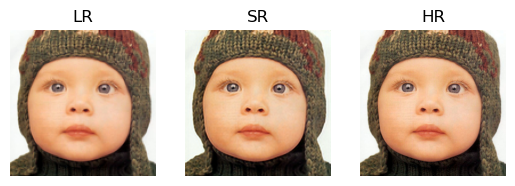

Fri Mar 24 18:30:06 2023	[2/5]	test [mse: 0.00161  ssim: 0.83143  psnr: 27.92009]


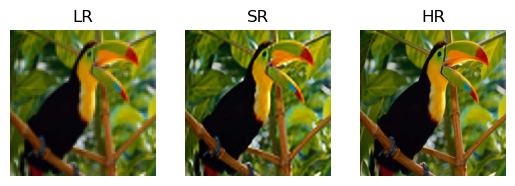

Fri Mar 24 18:30:06 2023	[3/5]	test [mse: 0.00574  ssim: 0.76499  psnr: 22.36286]


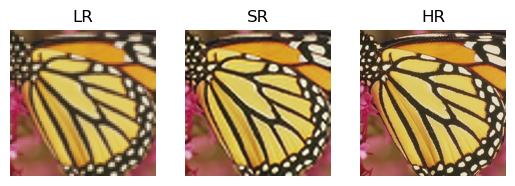

Fri Mar 24 18:30:07 2023	[4/5]	test [mse: 0.00127  ssim: 0.71139  psnr: 28.93104]


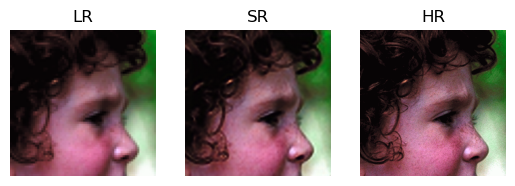

Fri Mar 24 18:30:07 2023	[5/5]	test [mse: 0.00240  ssim: 0.85178  psnr: 26.18890]


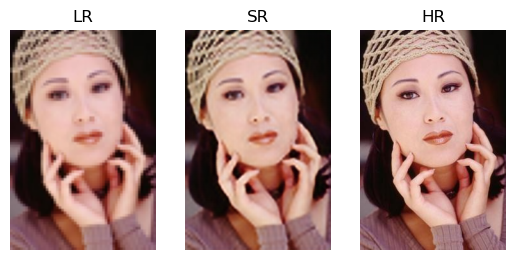

avg mse: 0.00238
avg ssim: 0.80386
avg psnr: 27.17587
total time: 2.76751 sec


In [11]:
test(test_dl, len(test_ds), sftmd, predictor, corrector, args)